# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
# sys.path.append('generative_models')
import sgm
from sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import src.utils as utils

!nvidia-smi

Sun Feb  9 00:31:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   30C    P0              22W / 250W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
!export PATH="/home/sobotka/MindEyeV2/src/generative_models":$PATH

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# First use "accelerate config" in terminal and setup using deepspeed stage 2 with CPU offloading!
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
if utils.is_interactive(): # set batch size here if using interactive notebook instead of submitting job
    global_batch_size = batch_size = 8
else:
    global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 2142529
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the 2nd cell block
    jupyter_args = f"--data_path=/weka/proj-medarc/shared/mindeyev2_dataset \
                    --cache_dir=/weka/proj-medarc/shared/cache \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} --num_sessions=40 \
                    --hidden_dim=1024 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5  \
                    --use_prior --prior_scale=30 \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --no-wandb_log"
    # --multisubject_ckpt=../train_logs/multisubject_subj01_1024_24bs_nolow

    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing
--data_path=/weka/proj-medarc/shared/mindeyev2_dataset                     --cache_dir=/weka/proj-medarc/shared/cache                     --model_name=testing                     --no-multi_subject --subj=1 --batch_size=8 --num_sessions=40                     --hidden_dim=1024 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                      --use_prior --prior_scale=30                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --no-wandb_log
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=1,
    help="Number of training sessions to include",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=True,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--batch_size", type=int, default=16,
    help="Batch size can be increased by 10x if only training retreival submodule and not diffusion prior",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=150,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 40


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [32]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    num_samples_per_epoch = (750*num_sessions) // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 8 num_iterations_per_epoch = 3750 num_samples_per_epoch = 30000


In [7]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    if multi_subject:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
    else:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
    print(train_url)
    
    train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True)

    f = h5py.File(f'{data_path}/betas_all_subj0{s}_fp32_renorm.hdf5', 'r')
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu").to(data_type)
    num_voxels_list.append(betas[0].shape[-1])
    num_voxels[f'subj0{s}'] = betas[0].shape[-1]
    voxels[f'subj0{s}'] = betas
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
elif new_test: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Training with 40 sessions
/weka/proj-medarc/shared/mindeyev2_dataset/wds/subj01/train/{0..39}.tar
num_voxels for subj01: 15724
Loaded all subj train dls and betas!

/weka/proj-medarc/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!



In [8]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images']
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! (73000, 3, 224, 224)


## Load models

### CLIP image embeddings  model

In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
    cache_dir="/scratch/izar/sobotka/mindeye/cache",
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

### SD VAE

In [12]:
blurry_recon = True
cache_dir = "/scratch/izar/sobotka/mindeye/cache" 

In [18]:
if blurry_recon:
    from diffusers import AutoencoderKL    
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)
    
    from src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cache_dir}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(device)
    utils.count_params(cnx)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(device).reshape(1,3,1,1)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [19]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [47]:
num_voxels_list = [8500]
hidden_dim = 1024
n_blocks = 3
clip_scale = 1.
use_prior = True
max_lr = 3e-4
prior_scale = 30
num_epochs = 150
num_iterations_per_epoch = 500
lr_scheduler_type = 'cycle'
outdir = f'/scratch/izar/sobotka/mindeye/train_logs/{model_name}'

In [24]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
8,705,024 total
8,705,024 trainable
param counts:
8,705,024 total
8,705,024 trainable
torch.Size([2, 1, 8500]) torch.Size([2, 1, 1024])


In [34]:
from src.models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, n_blocks=n_blocks,
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, 
                          blurry_recon=blurry_recon, clip_scale=clip_scale)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
456,783,862 total
456,783,862 trainable
param counts:
465,488,886 total
465,488,886 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [37]:
if use_prior:
    from src.models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = PriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
259,865,216 total
259,865,200 trainable
param counts:
725,354,102 total
725,354,086 trainable


### Setup optimizer / lr / ckpt saving

In [48]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 75000

Done with model preparations!
param counts:
725,354,102 total
725,354,086 trainable


# Weights and Biases

In [16]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeye'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Main

In [49]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [18]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

In [51]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

# model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
model, optimizer, lr_scheduler = accelerator.prepare(model, optimizer, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [93]:
mixup_pct = 0
blur_scale = 0.5

In [ ]:
blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)


In [106]:
### Test
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))


loss_prior_total = 0
loss_clip_total = 0
loss_blurry_total = 0
loss_blurry_cont_total = 0
recon_cossim = 0
recon_mse = 0
fwd_percent_correct = 0
bwd_percent_correct = 0
blurry_pixcorr = 0
loss = 0

image = torch.randn(8,3,224,224).cuda()
resp = torch.randn(8,1,8500).cuda()

clip_target = clip_img_embedder(image)
voxel_ridge_list = [model.ridge(resp,0)]
voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)


if clip_scale>0:
    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1).to(data_type)
    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1).to(data_type)

if use_prior:
    loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
    loss_prior_total += loss_prior.item()
    loss_prior *= prior_scale
    loss += loss_prior

    recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
    recon_mse += mse(prior_out, clip_target).item()

if clip_scale>0:
    if epoch < int(mixup_pct * num_epochs):                
        loss_clip = utils.mixco_nce(
            clip_voxels_norm,
            clip_target_norm,
            temp=.006,
            perm=perm, betas=betas, select=select)
    else:
        epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
        loss_clip = utils.soft_clip_loss(
            clip_voxels_norm,
            clip_target_norm,
            temp=epoch_temp)

    loss_clip_total += loss_clip.item()
    loss_clip *= clip_scale
    loss += loss_clip

if blurry_recon:     
    image_enc_pred, transformer_feats = blurry_image_enc_

    image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
    loss_blurry = l1(image_enc_pred, image_enc)
    loss_blurry_total += loss_blurry.item()

    if epoch < int(mixup_pct * num_epochs):
        image_enc_shuf = image_enc[perm]
        betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
        image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
            image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

    image_norm = (image - mean)/std
    image_aug = (blur_augs(image) - mean)/std
    _, cnx_embeds = cnx(image_norm)
    _, cnx_aug_embeds = cnx(image_aug)

    cont_loss = utils.soft_cont_loss(
        nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
        nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
        nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
        temp=0.2)
    loss_blurry_cont_total += cont_loss.item()

    loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

if clip_scale>0:
    # forward and backward top 1 accuracy        
    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
    fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
    bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

if blurry_recon:
    with torch.no_grad():
        # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
        random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
        blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
        pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
        blurry_pixcorr += pixcorr.item()

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


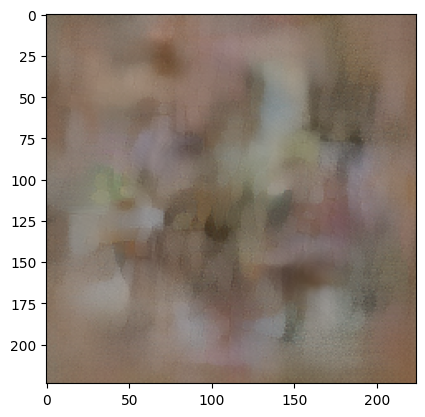

In [107]:
plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().numpy())
plt.show()

In [20]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    annot_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            iter = -1
            for behav0, past_behav0, future_behav0, old_behav0 in train_dl: 
                # Load images to cpu from hdf5 (requires sorted indexing)
                image_idx = behav0[:,0,0].cpu().long().numpy()
                image0, image_sorted_idx = np.unique(image_idx, return_index=True)                
                if len(image0) != len(image_idx): # hdf5 cant handle duplicate indexing
                    continue
                iter += 1
                image0 = torch.tensor(images[image0], dtype=data_type)
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0
                
                # Load voxels for current batch, matching above indexing
                voxel_idx = behav0[:,0,5].cpu().long().numpy()
                voxel_sorted_idx = voxel_idx[image_sorted_idx]
                voxel0 = voxels[f'subj0{subj_list[s]}'][voxel_sorted_idx]
                voxel0 = torch.Tensor(voxel0).unsqueeze(1)

                if epoch < int(mixup_pct * num_epochs):
                    voxel0, perm, betas, select = utils.mixco(voxel0)
                    perm_iters[f"subj0{subj_list[s]}_iter{iter}"] = perm
                    betas_iters[f"subj0{subj_list[s]}_iter{iter}"] = betas
                    select_iters[f"subj0{subj_list[s]}_iter{iter}"] = select

                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0

                if iter >= num_iterations_per_epoch-1:
                    break

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss=0.

            voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
            image = image_iters[train_i].detach()
            image = image.to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                betas = torch.cat(betas_list, dim=0)
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                select = torch.cat(select_list, dim=0)

            voxel_ridge_list = [model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test

                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()].unsqueeze(1)
                    
                    image = behav[:,0,0].cpu().long()

                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if len(locs)==1:
                            locs = locs.repeat(3)
                        elif len(locs)==2:
                            locs = locs.repeat(2)[:3]
                        assert len(locs)==3
                        if test_image is None:
                            test_image = torch.Tensor(images[im][None])
                            test_voxel = voxel[locs][None]
                        else:
                            test_image = torch.vstack((test_image, torch.Tensor(images[im][None])))
                            test_voxel = torch.vstack((test_voxel, voxel[locs][None]))

                loss=0.
                            
                test_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[test_indices].to(device)
                image = test_image[test_indices].to(device)
                assert len(image) == 300

                clip_target = clip_img_embedder(image.float())

                for rep in range(3):
                    voxel_ridge = model.ridge(voxel[:,rep],0) # 0th index of subj_list
                    backbone0, clip_voxels0, blurry_image_enc_ = model.backbone(voxel_ridge)
                    if rep==0:
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                    else:
                        clip_voxels += clip_voxels0
                        backbone += backbone0
                clip_voxels /= 3
                backbone /= 3

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')

testing starting with epoch 0 / 150


  2%|█████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 3/150 [29:23<24:00:08, 587.81s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=1.17, test/loss_prior=0.433, test/num_steps=3, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.77, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0, train/bwd_pct_correct=0.76, train/fwd_pct_correct=0.732, train/loss=13.2

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()